In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from minisom import MiniSom

In [2]:
dataset=pd.read_csv('Credit_Card_Applications.csv')
dataset.head()

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
0,15776156,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,15739548,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,15662854,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,15687688,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,15715750,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


In [3]:
X=dataset.iloc[:, :-1].values
Y=dataset.iloc[:,-1].values

In [4]:
sc=MinMaxScaler(feature_range=(0,1))
X=sc.fit_transform(X)
som=MiniSom(x=10,y=10,input_len=X.shape[1],sigma=1.0,learning_rate=0.5)

In [5]:
som.random_weights_init(X)
som.train_random(X,num_iteration=150,verbose=1)

 [ 150 / 150 ] 100% - 0:00:00 left 
 quantization error: 0.026012490039910637
 topographic error: 0.12753623188405797


In [6]:
from pylab import bone, pcolor, colorbar, plot, show

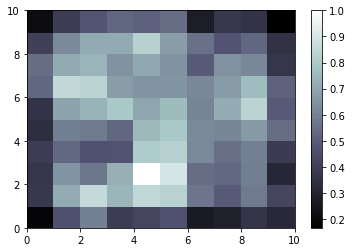

In [10]:
bone()
pcolor(som.distance_map().T)
colorbar()
show()

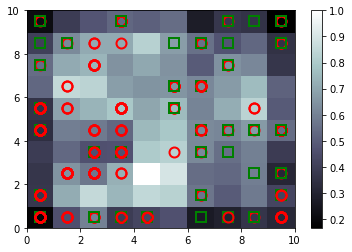

In [11]:
bone()
pcolor(som.distance_map().T)
colorbar()
markers=['o','s']
colors=['r','g']
for i,x in enumerate(X):
	w=som.winner(x)
	plot(w[0]+0.5,w[1]+0.5,markers[Y[i]],markeredgecolor=colors[Y[i]],markerfacecolor='None',markersize=10,markeredgewidth=2)
show()

In [12]:
mappings = som.win_map(X)
frauds= np.array(mappings[(7,7)])
frauds= sc.inverse_transform(frauds)

In [13]:
frauds

array([[1.5621546e+07, 1.0000000e+00, 4.0000000e+01, 6.5000000e+00,
        2.0000000e+00, 6.0000000e+00, 5.0000000e+00, 3.5000000e+00,
        1.0000000e+00, 1.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        2.0000000e+00, 0.0000000e+00, 5.0100000e+02],
       [1.5585855e+07, 1.0000000e+00, 4.0250000e+01, 2.1500000e+01,
        2.0000000e+00, 1.0000000e+01, 9.0000000e+00, 2.0000000e+01,
        1.0000000e+00, 1.0000000e+00, 1.1000000e+01, 0.0000000e+00,
        2.0000000e+00, 0.0000000e+00, 1.2010000e+03],
       [1.5661412e+07, 1.0000000e+00, 4.8750000e+01, 8.5000000e+00,
        2.0000000e+00, 8.0000000e+00, 8.0000000e+00, 1.2500000e+01,
        1.0000000e+00, 1.0000000e+00, 9.0000000e+00, 0.0000000e+00,
        2.0000000e+00, 1.8100000e+02, 1.6560000e+03],
       [1.5799785e+07, 1.0000000e+00, 5.6420000e+01, 2.8000000e+01,
        1.0000000e+00, 8.0000000e+00, 4.0000000e+00, 2.8500000e+01,
        1.0000000e+00, 1.0000000e+00, 4.0000000e+01, 0.0000000e+00,
        2.0000000e+00,

In [14]:
def rbf(x,c,s):
	return np.exp(-1/(2*s**2) * (x-c)**2)

In [17]:
def kmeans(X, k):
 # randomly select initial clusters from input data
    clusters = np.random.choice(np.squeeze(X), size=k)
    prevClusters = clusters.copy()
    stds = np.zeros(k)
    converged = False
    while not converged:
        distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
        closestCluster = np.argmin(distances, axis=1)
        for i in range(k):
            pointsForCluster = X[closestCluster == i]
            if len(pointsForCluster) > 0:
                clusters[i] = np.mean(pointsForCluster, axis=0)
        converged = np.linalg.norm(clusters - prevClusters) < 1e-6
        prevClusters = clusters.copy()
    distances = np.squeeze(np.abs(X[:, np.newaxis] - clusters[np.newaxis, :]))
    closestCluster = np.argmin(distances, axis=1)
    clustersWithNoPoints = []
    for i in range(k):
        pointsForCluster = X[closestCluster == i]
        if len(pointsForCluster) < 2:
            clustersWithNoPoints.append(i)
            continue
        else:
            stds[i] = np.std(X[closestCluster == i])
 # if there are clusters with 0 or 1 points, take the mean std of the other clusters
    if len(clustersWithNoPoints) > 0:
        pointsToAverage = []
        for i in range(k):
            if i not in clustersWithNoPoints:
                pointsToAverage.append(X[closestCluster == i])
        pointsToAverage = np.concatenate(pointsToAverage).ravel()
        stds[clustersWithNoPoints] = np.mean(np.std(pointsToAverage))
    return clusters, stds

In [22]:
class RBFNet(object):
    def __init__(self, k=2, lr=0.01, epochs=100, rbf=rbf, inferStds=True):
        self.k = k
        self.lr = lr
        self.epochs = epochs
        self.rbf = rbf
        self.inferStds = inferStds
        self.w = np.random.randn(k)
        self.b = np.random.randn(1)
    def fit(self, X, y):
        if self.inferStds:
# compute stds from data
            self.centers, self.stds = kmeans(X, self.k)
        else:
# use a fixed std
            self.centers, _ = kmeans(X, self.k)
            dMax = max([np.abs(c1 - c2) for c1 in self.centers for c2 in self.centers])
            self.stds = np.repeat(dMax / np.sqrt(2*self.k), self.k)
# training
        for epoch in range(self.epochs):
            for i in range(X.shape[0]):
# forward pass
                a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
                F = a.T.dot(self.w) + self.b
                loss = (y[i] - F).flatten() ** 2
                print('Loss: {0:.2f}'.format(loss[0]))
# backward pass
                error = -(y[i] - F).flatten()
 # online update
                self.w = self.w - self.lr * a * error
                self.b = self.b - self.lr * error
    def predict(self, X):
        y_pred = []
        for i in range(X.shape[0]):
            a = np.array([self.rbf(X[i], c, s) for c, s, in zip(self.centers, self.stds)])
            F = a.T.dot(self.w) + self.b
            y_pred.append(F)
        return np.array(y_pred)

In [23]:
import numpy as np
import matplotlib.pyplot as plt
# sample inputs and add noise
NUM_SAMPLES = 100
X = np.random.uniform(0., 1., NUM_SAMPLES)
X = np.sort(X, axis=0)
noise = np.random.uniform(-0.1, 0.1, NUM_SAMPLES)
y = np.sin(2 * np.pi * X) + noise
rbfnet = RBFNet(lr=1e-2, k=2)
rbfnet.fit(X, y)
y_pred = rbfnet.predict(X)


Loss: 2.05
Loss: 1.91
Loss: 1.62
Loss: 1.10
Loss: 1.22
Loss: 1.14
Loss: 0.97
Loss: 0.93
Loss: 0.84
Loss: 0.76
Loss: 0.45
Loss: 0.31
Loss: 0.25
Loss: 0.37
Loss: 0.23
Loss: 0.24
Loss: 0.12
Loss: 0.20
Loss: 0.20
Loss: 0.11
Loss: 0.16
Loss: 0.05
Loss: 0.03
Loss: 0.01
Loss: 0.05
Loss: 0.03
Loss: 0.02
Loss: 0.05
Loss: 0.01
Loss: 0.05
Loss: 0.00
Loss: 0.03
Loss: 0.03
Loss: 0.01
Loss: 0.01
Loss: 0.03
Loss: 0.01
Loss: 0.01
Loss: 0.03
Loss: 0.03
Loss: 0.08
Loss: 0.05
Loss: 0.13
Loss: 0.22
Loss: 0.15
Loss: 0.14
Loss: 0.10
Loss: 0.18
Loss: 0.14
Loss: 0.13
Loss: 0.19
Loss: 0.25
Loss: 0.32
Loss: 0.57
Loss: 0.45
Loss: 0.36
Loss: 0.62
Loss: 0.48
Loss: 0.58
Loss: 0.74
Loss: 0.94
Loss: 0.93
Loss: 0.97
Loss: 0.94
Loss: 0.96
Loss: 0.82
Loss: 0.69
Loss: 0.67
Loss: 0.73
Loss: 0.77
Loss: 0.65
Loss: 0.47
Loss: 0.65
Loss: 0.63
Loss: 0.39
Loss: 0.61
Loss: 0.44
Loss: 0.53
Loss: 0.47
Loss: 0.44
Loss: 0.44
Loss: 0.49
Loss: 0.47
Loss: 0.37
Loss: 0.32
Loss: 0.36
Loss: 0.56
Loss: 0.52
Loss: 0.51
Loss: 0.49
Loss: 0.50

Loss: 0.02
Loss: 0.00
Loss: 0.04
Loss: 0.06
Loss: 0.08
Loss: 0.03
Loss: 0.04
Loss: 0.05
Loss: 0.02
Loss: 0.05
Loss: 0.01
Loss: 0.07
Loss: 0.02
Loss: 0.02
Loss: 0.06
Loss: 0.06
Loss: 0.03
Loss: 0.06
Loss: 0.05
Loss: 0.04
Loss: 0.03
Loss: 0.01
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.01
Loss: 0.00
Loss: 0.05
Loss: 0.02
Loss: 0.02
Loss: 0.05
Loss: 0.06
Loss: 0.04
Loss: 0.04
Loss: 0.03
Loss: 0.03
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.04
Loss: 0.01
Loss: 0.01
Loss: 0.06
Loss: 0.01
Loss: 0.03
Loss: 0.01
Loss: 0.02
Loss: 0.02
Loss: 0.02
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.02
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.02
Loss: 0.02
Loss: 0.03
Loss: 0.09
Loss: 0.02
Loss: 0.08
Loss: 0.04
Loss: 0.04
Loss: 0.05
Loss: 0.04
Loss: 0.02
Loss: 0.36
Loss: 0.32
Loss: 0.23
Loss: 0.08
Loss: 0.12
Loss: 0.11
Loss: 0.07
Loss: 0.06
Loss: 0.05
Loss: 0.04

Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.01
Loss: 0.01
Loss: 0.03
Loss: 0.03
Loss: 0.02
Loss: 0.02
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.05
Loss: 0.01
Loss: 0.01
Loss: 0.08
Loss: 0.01
Loss: 0.04
Loss: 0.02
Loss: 0.03
Loss: 0.03
Loss: 0.03
Loss: 0.01
Loss: 0.01
Loss: 0.03
Loss: 0.03
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.06
Loss: 0.01
Loss: 0.05
Loss: 0.02
Loss: 0.02
Loss: 0.02
Loss: 0.01
Loss: 0.00
Loss: 0.30
Loss: 0.28
Loss: 0.20
Loss: 0.06
Loss: 0.10
Loss: 0.09
Loss: 0.06
Loss: 0.05
Loss: 0.04
Loss: 0.04
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.02
Loss: 0.03
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.03
Loss: 0.01
Loss: 0.03
Loss: 0.03
Loss: 0.02
Loss: 0.02
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00

Loss: 0.01
Loss: 0.01
Loss: 0.04
Loss: 0.00
Loss: 0.04
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.25
Loss: 0.23
Loss: 0.17
Loss: 0.05
Loss: 0.08
Loss: 0.08
Loss: 0.05
Loss: 0.04
Loss: 0.03
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.02
Loss: 0.01
Loss: 0.02
Loss: 0.02
Loss: 0.02
Loss: 0.02
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.02
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.04
Loss: 0.01
Loss: 0.01
Loss: 0.06
Loss: 0.01
Loss: 0.03
Loss: 0.01
Loss: 0.02
Loss: 0.02
Loss: 0.02

Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.02
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.04
Loss: 0.00
Loss: 0.03
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.21
Loss: 0.19
Loss: 0.14
Loss: 0.03
Loss: 0.06
Loss: 0.06
Loss: 0.04
Loss: 0.03
Loss: 0.02
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.02
Loss: 0.02
Loss: 0.01
Loss: 0.02
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.01
Loss: 0.02
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.02
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00

Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.02
Loss: 0.02
Loss: 0.01
Loss: 0.02
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.02
Loss: 0.00
Loss: 0.01
Loss: 0.02
Loss: 0.02
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.04
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.02
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.03
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.18
Loss: 0.17
Loss: 0.12
Loss: 0.02
Loss: 0.05
Loss: 0.05
Loss: 0.03
Loss: 0.03
Loss: 0.02
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00

Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.02
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.15
Loss: 0.14
Loss: 0.10
Loss: 0.02
Loss: 0.04
Loss: 0.04
Loss: 0.02
Loss: 0.02
Loss: 0.01
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.02
Loss: 0.00
Loss: 0.01
Loss: 0.02
Loss: 0.02
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.00

Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.13
Loss: 0.13
Loss: 0.09
Loss: 0.01
Loss: 0.03
Loss: 0.03
Loss: 0.02
Loss: 0.02
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.03
Loss: 0.00
Loss: 0.01
Loss: 0.02
Loss: 0.02
Loss: 0.02
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00

Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.12
Loss: 0.12
Loss: 0.08
Loss: 0.01
Loss: 0.03
Loss: 0.03
Loss: 0.02
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.03
Loss: 0.00
Loss: 0.02
Loss: 0.03
Loss: 0.02
Loss: 0.02
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00

Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.03
Loss: 0.11
Loss: 0.11
Loss: 0.07
Loss: 0.01
Loss: 0.03
Loss: 0.03
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.03
Loss: 0.00
Loss: 0.02
Loss: 0.03
Loss: 0.03
Loss: 0.02
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01

Loss: 0.02
Loss: 0.03
Loss: 0.03
Loss: 0.02
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.03


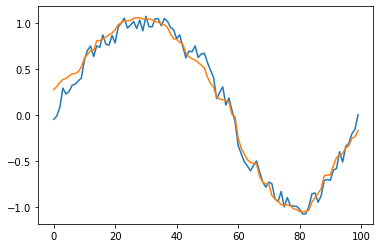

In [25]:
plot(y)
plot(y_pred)

Loss: 0.90
Loss: 0.50
Loss: 0.26
Loss: 0.36
Loss: 0.28
Loss: 0.19
Loss: 0.19
Loss: 0.21
Loss: 0.07
Loss: 0.01
Loss: 0.02
Loss: 0.00
Loss: 0.02
Loss: 0.01
Loss: 0.02
Loss: 0.02
Loss: 0.05
Loss: 0.03
Loss: 0.10
Loss: 0.12
Loss: 0.09
Loss: 0.41
Loss: 0.53
Loss: 0.48
Loss: 0.50
Loss: 0.69
Loss: 0.75
Loss: 0.68
Loss: 0.85
Loss: 1.14
Loss: 0.82
Loss: 0.87
Loss: 1.02
Loss: 0.59
Loss: 0.25
Loss: 0.31
Loss: 0.10
Loss: 0.03
Loss: 0.00
Loss: 0.14
Loss: 0.17
Loss: 0.31
Loss: 0.27
Loss: 0.43
Loss: 1.13
Loss: 1.07
Loss: 1.23
Loss: 1.23
Loss: 1.41
Loss: 1.62
Loss: 4.36
Loss: 6.28
Loss: 6.25
Loss: 6.32
Loss: 6.00
Loss: 5.79
Loss: 5.71
Loss: 6.47
Loss: 6.11
Loss: 5.64
Loss: 5.25
Loss: 4.80
Loss: 4.29
Loss: 4.13
Loss: 4.23
Loss: 4.06
Loss: 3.67
Loss: 3.07
Loss: 2.55
Loss: 2.71
Loss: 2.11
Loss: 1.87
Loss: 1.26
Loss: 0.99
Loss: 0.44
Loss: 0.36
Loss: 0.38
Loss: 0.36
Loss: 0.16
Loss: 0.04
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.03
Loss: 0.09
Loss: 0.14
Loss: 0.04
Loss: 0.03
Loss: 0.08
Loss: 0.07

Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.02
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.07
Loss: 0.06
Loss: 0.04
Loss: 0.13
Loss: 0.24
Loss: 0.20
Loss: 0.21
Loss: 0.45
Loss: 0.44
Loss: 0.48
Loss: 0.35
Loss: 0.37
Loss: 0.69
Loss: 0.57
Loss: 0.67
Loss: 0.48
Loss: 0.46
Loss: 0.19
Loss: 0.16
Loss: 0.18
Loss: 0.18
Loss: 0.06
Loss: 0.01
Loss: 0.02
Loss: 0.00
Loss: 0.01
Loss: 0.02
Loss: 0.03
Loss: 0.10
Loss: 0.15
Loss: 0.04
Loss: 0.04
Loss: 0.09
Loss: 0.08
Loss: 0.03
Loss: 0.11
Loss: 0.06
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.14
Loss: 0.03
Loss: 0.01
Loss: 0.04
Loss: 0.03
Loss: 0.01
Loss: 0.03
Loss: 0.05
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.09
Loss: 0.14
Loss: 0.14
Loss: 0.22
Loss: 0.19
Loss: 0.29
Loss: 0.32
Loss: 0.22
Loss: 0.43
Loss: 0.47
Loss: 0.39
Loss: 0.35
Loss: 0.34
Loss: 0.26
Loss: 0.21

Loss: 0.04
Loss: 0.09
Loss: 0.07
Loss: 0.09
Loss: 0.09
Loss: 0.08
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.01
Loss: 0.05
Loss: 0.04
Loss: 0.05
Loss: 0.22
Loss: 0.21
Loss: 0.26
Loss: 0.18
Loss: 0.22
Loss: 0.51
Loss: 0.44
Loss: 0.56
Loss: 0.41
Loss: 0.42
Loss: 0.18
Loss: 0.15
Loss: 0.17
Loss: 0.17
Loss: 0.06
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.08
Loss: 0.13
Loss: 0.03
Loss: 0.03
Loss: 0.08
Loss: 0.07
Loss: 0.02
Loss: 0.10
Loss: 0.05
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.14
Loss: 0.04
Loss: 0.03
Loss: 0.07
Loss: 0.05
Loss: 0.03
Loss: 0.05
Loss: 0.09
Loss: 0.05
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.05
Loss: 0.10
Loss: 0.09
Loss: 0.17
Loss: 0.13
Loss: 0.22
Loss: 0.24
Loss: 0.14
Loss: 0.26
Loss: 0.27
Loss: 0.20
Loss: 0.17
Loss: 0.13
Loss: 0.07
Loss: 0.04
Loss: 0.08
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.01
Loss: 0.02
Loss: 0.00
Loss: 0.01

Loss: 0.14
Loss: 0.17
Loss: 0.16
Loss: 0.06
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.08
Loss: 0.13
Loss: 0.03
Loss: 0.03
Loss: 0.07
Loss: 0.06
Loss: 0.02
Loss: 0.10
Loss: 0.05
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.12
Loss: 0.03
Loss: 0.02
Loss: 0.06
Loss: 0.05
Loss: 0.03
Loss: 0.06
Loss: 0.09
Loss: 0.05
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.05
Loss: 0.09
Loss: 0.09
Loss: 0.16
Loss: 0.13
Loss: 0.21
Loss: 0.24
Loss: 0.13
Loss: 0.23
Loss: 0.24
Loss: 0.17
Loss: 0.13
Loss: 0.09
Loss: 0.03
Loss: 0.01
Loss: 0.05
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.06
Loss: 0.02
Loss: 0.02
Loss: 0.05
Loss: 0.02
Loss: 0.03
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.07
Loss: 0.07
Loss: 0.14
Loss: 0.10
Loss: 0.13
Loss: 0.13
Loss: 0.12
Loss: 0.02
Loss: 0.02
Loss: 0.04
Loss: 0.00
Loss: 0.03
Loss: 0.02
Loss: 0.03
Loss: 0.18
Loss: 0.17

Loss: 0.08
Loss: 0.03
Loss: 0.01
Loss: 0.04
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.03
Loss: 0.07
Loss: 0.02
Loss: 0.02
Loss: 0.06
Loss: 0.02
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.02
Loss: 0.02
Loss: 0.01
Loss: 0.02
Loss: 0.08
Loss: 0.07
Loss: 0.14
Loss: 0.10
Loss: 0.13
Loss: 0.13
Loss: 0.12
Loss: 0.02
Loss: 0.02
Loss: 0.04
Loss: 0.00
Loss: 0.03
Loss: 0.02
Loss: 0.03
Loss: 0.17
Loss: 0.16
Loss: 0.21
Loss: 0.14
Loss: 0.17
Loss: 0.44
Loss: 0.37
Loss: 0.49
Loss: 0.36
Loss: 0.38
Loss: 0.16
Loss: 0.14
Loss: 0.16
Loss: 0.16
Loss: 0.06
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.07
Loss: 0.12
Loss: 0.03
Loss: 0.03
Loss: 0.07
Loss: 0.06
Loss: 0.02
Loss: 0.09
Loss: 0.05
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.10
Loss: 0.03
Loss: 0.02
Loss: 0.06
Loss: 0.04
Loss: 0.03
Loss: 0.06
Loss: 0.09
Loss: 0.06
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.05
Loss: 0.09
Loss: 0.09

Loss: 0.06
Loss: 0.10
Loss: 0.07
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.05
Loss: 0.09
Loss: 0.09
Loss: 0.17
Loss: 0.14
Loss: 0.23
Loss: 0.25
Loss: 0.14
Loss: 0.23
Loss: 0.23
Loss: 0.16
Loss: 0.13
Loss: 0.08
Loss: 0.02
Loss: 0.01
Loss: 0.03
Loss: 0.00
Loss: 0.02
Loss: 0.01
Loss: 0.00
Loss: 0.04
Loss: 0.08
Loss: 0.03
Loss: 0.02
Loss: 0.06
Loss: 0.02
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.02
Loss: 0.02
Loss: 0.01
Loss: 0.02
Loss: 0.08
Loss: 0.07
Loss: 0.13
Loss: 0.10
Loss: 0.12
Loss: 0.12
Loss: 0.11
Loss: 0.02
Loss: 0.02
Loss: 0.03
Loss: 0.00
Loss: 0.03
Loss: 0.02
Loss: 0.03
Loss: 0.16
Loss: 0.16
Loss: 0.20
Loss: 0.13
Loss: 0.16
Loss: 0.42
Loss: 0.36
Loss: 0.47
Loss: 0.35
Loss: 0.36
Loss: 0.15
Loss: 0.13
Loss: 0.16
Loss: 0.16
Loss: 0.06
Loss: 0.02
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.06
Loss: 0.12
Loss: 0.03
Loss: 0.02
Loss: 0.07
Loss: 0.06
Loss: 0.02
Loss: 0.09
Loss: 0.05
Loss: 0.01
Loss: 0.01
Loss: 0.00

Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.06
Loss: 0.11
Loss: 0.02
Loss: 0.02
Loss: 0.06
Loss: 0.06
Loss: 0.02
Loss: 0.09
Loss: 0.05
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.08
Loss: 0.02
Loss: 0.02
Loss: 0.05
Loss: 0.04
Loss: 0.03
Loss: 0.06
Loss: 0.10
Loss: 0.07
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.05
Loss: 0.09
Loss: 0.10
Loss: 0.17
Loss: 0.14
Loss: 0.23
Loss: 0.26
Loss: 0.15
Loss: 0.24
Loss: 0.23
Loss: 0.17
Loss: 0.13
Loss: 0.08
Loss: 0.02
Loss: 0.01
Loss: 0.03
Loss: 0.00
Loss: 0.02
Loss: 0.01
Loss: 0.00
Loss: 0.04
Loss: 0.08
Loss: 0.03
Loss: 0.02
Loss: 0.06
Loss: 0.02
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.02
Loss: 0.02
Loss: 0.02
Loss: 0.01
Loss: 0.02
Loss: 0.08
Loss: 0.07
Loss: 0.12
Loss: 0.09
Loss: 0.11
Loss: 0.12
Loss: 0.10
Loss: 0.01
Loss: 0.02
Loss: 0.03
Loss: 0.00
Loss: 0.03
Loss: 0.02
Loss: 0.03
Loss: 0.16
Loss: 0.16
Loss: 0.20
Loss: 0.13
Loss: 0.15
Loss: 0.41
Loss: 0.34

Loss: 0.26
Loss: 0.15
Loss: 0.24
Loss: 0.24
Loss: 0.17
Loss: 0.13
Loss: 0.08
Loss: 0.02
Loss: 0.01
Loss: 0.03
Loss: 0.00
Loss: 0.03
Loss: 0.01
Loss: 0.00
Loss: 0.04
Loss: 0.09
Loss: 0.03
Loss: 0.02
Loss: 0.06
Loss: 0.02
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.03
Loss: 0.02
Loss: 0.02
Loss: 0.03
Loss: 0.08
Loss: 0.06
Loss: 0.12
Loss: 0.08
Loss: 0.11
Loss: 0.11
Loss: 0.10
Loss: 0.01
Loss: 0.02
Loss: 0.03
Loss: 0.00
Loss: 0.03
Loss: 0.02
Loss: 0.03
Loss: 0.16
Loss: 0.15
Loss: 0.19
Loss: 0.12
Loss: 0.15
Loss: 0.40
Loss: 0.33
Loss: 0.45
Loss: 0.32
Loss: 0.34
Loss: 0.14
Loss: 0.13
Loss: 0.15
Loss: 0.15
Loss: 0.05
Loss: 0.02
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.06
Loss: 0.11
Loss: 0.02
Loss: 0.02
Loss: 0.06
Loss: 0.05
Loss: 0.02
Loss: 0.09
Loss: 0.05
Loss: 0.01
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.07
Loss: 0.01
Loss: 0.02
Loss: 0.05
Loss: 0.04
Loss: 0.03
Loss: 0.06
Loss: 0.10
Loss: 0.08
Loss: 0.01

Loss: 0.00
Loss: 0.02
Loss: 0.03
Loss: 0.03
Loss: 0.02
Loss: 0.03
Loss: 0.07
Loss: 0.06
Loss: 0.11
Loss: 0.08
Loss: 0.10
Loss: 0.11
Loss: 0.09
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.00
Loss: 0.03
Loss: 0.02
Loss: 0.03
Loss: 0.16
Loss: 0.15
Loss: 0.19
Loss: 0.12
Loss: 0.14
Loss: 0.39
Loss: 0.32
Loss: 0.43
Loss: 0.31
Loss: 0.34
Loss: 0.14
Loss: 0.13
Loss: 0.15
Loss: 0.15
Loss: 0.05
Loss: 0.02
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.05
Loss: 0.10
Loss: 0.02
Loss: 0.02
Loss: 0.06
Loss: 0.05
Loss: 0.01
Loss: 0.08
Loss: 0.05
Loss: 0.01
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.06
Loss: 0.01
Loss: 0.02
Loss: 0.05
Loss: 0.04
Loss: 0.03
Loss: 0.06
Loss: 0.11
Loss: 0.09
Loss: 0.01
Loss: 0.02
Loss: 0.00
Loss: 0.01
Loss: 0.05
Loss: 0.09
Loss: 0.10
Loss: 0.17
Loss: 0.15
Loss: 0.24
Loss: 0.27
Loss: 0.16
Loss: 0.24
Loss: 0.24
Loss: 0.17
Loss: 0.13
Loss: 0.08
Loss: 0.02
Loss: 0.00
Loss: 0.03
Loss: 0.00
Loss: 0.03
Loss: 0.02
Loss: 0.01
Loss: 0.05
Loss: 0.09

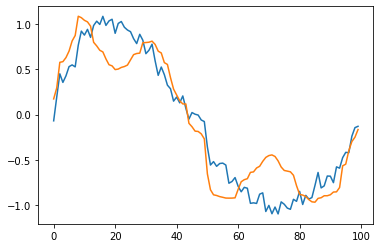

In [26]:
NUM_SAMPLES = 100
X = np.random.uniform(0., 1., NUM_SAMPLES)
X = np.sort(X, axis=0)
noise = np.random.uniform(-0.1, 0.1, NUM_SAMPLES)
y = np.sin(2 * np.pi * X) + noise
rbfnet = RBFNet(lr=1e-2, k=4)
rbfnet.fit(X, y)
y_pred = rbfnet.predict(X)
plot(y)
plot(y_pred)

Al aumentar el numero de bases a 4 se observa curvas de campana muy pronunciadas.

Loss: 0.03
Loss: 0.05
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.06
Loss: 0.03
Loss: 0.09
Loss: 0.05
Loss: 0.02
Loss: 0.04
Loss: 0.03
Loss: 0.07
Loss: 0.02
Loss: 0.10
Loss: 0.02
Loss: 0.03
Loss: 0.04
Loss: 0.02
Loss: 0.04
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.06
Loss: 0.10
Loss: 0.08
Loss: 0.09
Loss: 0.13
Loss: 0.33
Loss: 0.56
Loss: 0.62
Loss: 0.59
Loss: 0.71
Loss: 0.58
Loss: 0.65
Loss: 1.17
Loss: 1.05
Loss: 1.01
Loss: 1.21
Loss: 1.14
Loss: 1.51
Loss: 1.18
Loss: 1.36
Loss: 1.36
Loss: 1.19
Loss: 1.31
Loss: 1.32
Loss: 1.31
Loss: 1.42
Loss: 1.55
Loss: 1.31
Loss: 1.49
Loss: 1.54
Loss: 1.74
Loss: 1.89
Loss: 1.85
Loss: 2.08
Loss: 1.86
Loss: 1.78
Loss: 2.24
Loss: 1.98
Loss: 1.86
Loss: 2.68
Loss: 3.16
Loss: 2.53
Loss: 2.70
Loss: 2.68
Loss: 2.97
Loss: 3.14
Loss: 2.44
Loss: 2.63
Loss: 2.60
Loss: 2.27
Loss: 2.43
Loss: 2.04
Loss: 1.98
Loss: 1.90
Loss: 1.42
Loss: 1.10
Loss: 0.89
Loss: 1.00
Loss: 0.88
Loss: 0.67
Loss: 0.40

Loss: 0.02
Loss: 0.01
Loss: 0.03
Loss: 0.03
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.05
Loss: 0.06
Loss: 0.04
Loss: 0.08
Loss: 0.04
Loss: 0.04
Loss: 0.13
Loss: 0.09
Loss: 0.06
Loss: 0.11
Loss: 0.09
Loss: 0.15
Loss: 0.06
Loss: 0.12
Loss: 0.11
Loss: 0.07
Loss: 0.11
Loss: 0.12
Loss: 0.12
Loss: 0.16
Loss: 0.18
Loss: 0.08
Loss: 0.14
Loss: 0.12
Loss: 0.10
Loss: 0.14
Loss: 0.10
Loss: 0.13
Loss: 0.09
Loss: 0.07
Loss: 0.17
Loss: 0.10
Loss: 0.09
Loss: 0.12
Loss: 0.16
Loss: 0.05
Loss: 0.06
Loss: 0.06
Loss: 0.12
Loss: 0.10
Loss: 0.02
Loss: 0.04
Loss: 0.04
Loss: 0.01
Loss: 0.03
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.03
Loss: 0.05
Loss: 0.02
Loss: 0.02
Loss: 0.03
Loss: 0.13
Loss: 0.21
Loss: 0.16
Loss: 0.27
Loss: 0.22
Loss: 0.31
Loss: 0.34
Loss: 0.18
Loss: 0.39
Loss: 0.48
Loss: 0.02
Loss: 0.01
Loss: 0.06
Loss: 0.07
Loss: 0.10
Loss: 0.18
Loss: 0.23
Loss: 0.17
Loss: 0.26
Loss: 0.18
Loss: 0.12
Loss: 0.17
Loss: 0.14
Loss: 0.21
Loss: 0.11
Loss: 0.26

Loss: 0.06
Loss: 0.17
Loss: 0.05
Loss: 0.08
Loss: 0.09
Loss: 0.06
Loss: 0.11
Loss: 0.03
Loss: 0.06
Loss: 0.04
Loss: 0.06
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.05
Loss: 0.06
Loss: 0.04
Loss: 0.07
Loss: 0.03
Loss: 0.03
Loss: 0.11
Loss: 0.08
Loss: 0.04
Loss: 0.08
Loss: 0.07
Loss: 0.11
Loss: 0.04
Loss: 0.09
Loss: 0.08
Loss: 0.05
Loss: 0.08
Loss: 0.09
Loss: 0.09
Loss: 0.13
Loss: 0.14
Loss: 0.06
Loss: 0.11
Loss: 0.09
Loss: 0.07
Loss: 0.09
Loss: 0.06
Loss: 0.09
Loss: 0.05
Loss: 0.04
Loss: 0.12
Loss: 0.06
Loss: 0.05
Loss: 0.06
Loss: 0.09
Loss: 0.02
Loss: 0.02
Loss: 0.02
Loss: 0.06
Loss: 0.05
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.05
Loss: 0.07
Loss: 0.03
Loss: 0.04
Loss: 0.04
Loss: 0.14
Loss: 0.21
Loss: 0.16
Loss: 0.24
Loss: 0.19
Loss: 0.27
Loss: 0.29
Loss: 0.15
Loss: 0.32
Loss: 0.40
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.02

Loss: 0.08
Loss: 0.05
Loss: 0.10
Loss: 0.02
Loss: 0.06
Loss: 0.04
Loss: 0.07
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.02
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.04
Loss: 0.05
Loss: 0.03
Loss: 0.05
Loss: 0.02
Loss: 0.02
Loss: 0.09
Loss: 0.06
Loss: 0.03
Loss: 0.07
Loss: 0.06
Loss: 0.09
Loss: 0.03
Loss: 0.07
Loss: 0.07
Loss: 0.04
Loss: 0.07
Loss: 0.07
Loss: 0.08
Loss: 0.11
Loss: 0.12
Loss: 0.04
Loss: 0.09
Loss: 0.07
Loss: 0.05
Loss: 0.08
Loss: 0.05
Loss: 0.07
Loss: 0.04
Loss: 0.03
Loss: 0.10
Loss: 0.05
Loss: 0.04
Loss: 0.05
Loss: 0.07
Loss: 0.01
Loss: 0.02
Loss: 0.02
Loss: 0.05
Loss: 0.04
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.05
Loss: 0.07
Loss: 0.03
Loss: 0.03
Loss: 0.03
Loss: 0.12
Loss: 0.17
Loss: 0.12
Loss: 0.19
Loss: 0.14
Loss: 0.22
Loss: 0.23
Loss: 0.11
Loss: 0.25
Loss: 0.32
Loss: 0.04
Loss: 0.06
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.08
Loss: 0.04
Loss: 0.11

Loss: 0.26
Loss: 0.08
Loss: 0.11
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.02
Loss: 0.05
Loss: 0.03
Loss: 0.09
Loss: 0.05
Loss: 0.02
Loss: 0.05
Loss: 0.04
Loss: 0.08
Loss: 0.03
Loss: 0.12
Loss: 0.03
Loss: 0.06
Loss: 0.08
Loss: 0.05
Loss: 0.10
Loss: 0.02
Loss: 0.06
Loss: 0.04
Loss: 0.07
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.02
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.04
Loss: 0.02
Loss: 0.04
Loss: 0.02
Loss: 0.02
Loss: 0.07
Loss: 0.05
Loss: 0.02
Loss: 0.06
Loss: 0.05
Loss: 0.08
Loss: 0.02
Loss: 0.06
Loss: 0.05
Loss: 0.03
Loss: 0.06
Loss: 0.06
Loss: 0.06
Loss: 0.09
Loss: 0.11
Loss: 0.04
Loss: 0.08
Loss: 0.06
Loss: 0.04
Loss: 0.07
Loss: 0.04
Loss: 0.06
Loss: 0.03
Loss: 0.02
Loss: 0.09
Loss: 0.04
Loss: 0.03
Loss: 0.04
Loss: 0.06
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.04
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.05
Loss: 0.06
Loss: 0.03
Loss: 0.03
Loss: 0.02

Loss: 0.04
Loss: 0.02
Loss: 0.00
Loss: 0.01
Loss: 0.04
Loss: 0.02
Loss: 0.07
Loss: 0.04
Loss: 0.02
Loss: 0.04
Loss: 0.03
Loss: 0.07
Loss: 0.02
Loss: 0.11
Loss: 0.03
Loss: 0.06
Loss: 0.07
Loss: 0.05
Loss: 0.10
Loss: 0.02
Loss: 0.06
Loss: 0.04
Loss: 0.07
Loss: 0.01
Loss: 0.01
Loss: 0.03
Loss: 0.03
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.03
Loss: 0.02
Loss: 0.04
Loss: 0.01
Loss: 0.01
Loss: 0.06
Loss: 0.04
Loss: 0.02
Loss: 0.05
Loss: 0.04
Loss: 0.07
Loss: 0.02
Loss: 0.05
Loss: 0.05
Loss: 0.02
Loss: 0.05
Loss: 0.05
Loss: 0.06
Loss: 0.08
Loss: 0.10
Loss: 0.03
Loss: 0.07
Loss: 0.05
Loss: 0.04
Loss: 0.06
Loss: 0.03
Loss: 0.05
Loss: 0.02
Loss: 0.02
Loss: 0.08
Loss: 0.03
Loss: 0.03
Loss: 0.03
Loss: 0.05
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.04
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.05
Loss: 0.06
Loss: 0.02
Loss: 0.02
Loss: 0.02
Loss: 0.10
Loss: 0.12
Loss: 0.08

Loss: 0.04
Loss: 0.01
Loss: 0.04
Loss: 0.03
Loss: 0.06
Loss: 0.02
Loss: 0.05
Loss: 0.04
Loss: 0.02
Loss: 0.04
Loss: 0.05
Loss: 0.05
Loss: 0.08
Loss: 0.09
Loss: 0.03
Loss: 0.06
Loss: 0.05
Loss: 0.03
Loss: 0.05
Loss: 0.03
Loss: 0.05
Loss: 0.02
Loss: 0.01
Loss: 0.07
Loss: 0.03
Loss: 0.02
Loss: 0.03
Loss: 0.05
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.03
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.05
Loss: 0.06
Loss: 0.02
Loss: 0.02
Loss: 0.02
Loss: 0.09
Loss: 0.11
Loss: 0.07
Loss: 0.12
Loss: 0.07
Loss: 0.12
Loss: 0.13
Loss: 0.05
Loss: 0.13
Loss: 0.19
Loss: 0.19
Loss: 0.22
Loss: 0.06
Loss: 0.04
Loss: 0.01
Loss: 0.00
Loss: 0.03
Loss: 0.01
Loss: 0.05
Loss: 0.03
Loss: 0.01
Loss: 0.03
Loss: 0.02
Loss: 0.06
Loss: 0.02
Loss: 0.10
Loss: 0.02
Loss: 0.06
Loss: 0.07
Loss: 0.05
Loss: 0.10
Loss: 0.02
Loss: 0.06
Loss: 0.04
Loss: 0.08
Loss: 0.01
Loss: 0.01
Loss: 0.03
Loss: 0.03
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01

Loss: 0.03
Loss: 0.02
Loss: 0.06
Loss: 0.01
Loss: 0.09
Loss: 0.02
Loss: 0.06
Loss: 0.07
Loss: 0.05
Loss: 0.09
Loss: 0.02
Loss: 0.06
Loss: 0.04
Loss: 0.08
Loss: 0.01
Loss: 0.01
Loss: 0.03
Loss: 0.03
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.01
Loss: 0.00
Loss: 0.02
Loss: 0.02
Loss: 0.01
Loss: 0.03
Loss: 0.01
Loss: 0.01
Loss: 0.05
Loss: 0.03
Loss: 0.01
Loss: 0.04
Loss: 0.03
Loss: 0.06
Loss: 0.01
Loss: 0.04
Loss: 0.04
Loss: 0.02
Loss: 0.04
Loss: 0.04
Loss: 0.05
Loss: 0.07
Loss: 0.08
Loss: 0.02
Loss: 0.06
Loss: 0.04
Loss: 0.03
Loss: 0.05
Loss: 0.03
Loss: 0.04
Loss: 0.02
Loss: 0.01
Loss: 0.06
Loss: 0.03
Loss: 0.02
Loss: 0.03
Loss: 0.04
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.04
Loss: 0.06
Loss: 0.02
Loss: 0.02
Loss: 0.01
Loss: 0.08
Loss: 0.10
Loss: 0.06
Loss: 0.10
Loss: 0.06
Loss: 0.11
Loss: 0.12
Loss: 0.04
Loss: 0.11
Loss: 0.16
Loss: 0.25
Loss: 0.27

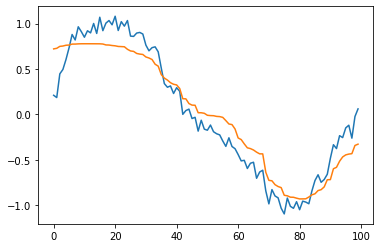

In [27]:
NUM_SAMPLES = 100
X = np.random.uniform(0., 1., NUM_SAMPLES)
X = np.sort(X, axis=0)
noise = np.random.uniform(-0.1, 0.1, NUM_SAMPLES)
y = np.sin(2 * np.pi * X) + noise
rbfnet = RBFNet(lr=1e-2, k=2,inferStds=False)
rbfnet.fit(X, y)
y_pred = rbfnet.predict(X)
plot(y)
plot(y_pred)

Al no inferir desviaciones estándar para cada base y usar una única, empeora el proceso, aunque no demasiado.

Realmente no hay que probar mucho en este caso porque es una función seno que tiene dos campanas, por lo que k=2 debe proporcionar el mejor resultado, no inferir desviaciones estándar en este caso empeora el resultado como se ve encima. Solo quedaría por ajustar el learning rate, es decir la tasa de aprendizaje y el número de épocas.

Loss: 0.04
Loss: 0.00
Loss: 0.06
Loss: 0.05
Loss: 0.05
Loss: 0.02
Loss: 0.04
Loss: 0.05
Loss: 0.17
Loss: 0.29
Loss: 0.49
Loss: 0.48
Loss: 0.62
Loss: 0.43
Loss: 0.47
Loss: 0.61
Loss: 0.69
Loss: 0.89
Loss: 0.69
Loss: 0.89
Loss: 0.84
Loss: 0.59
Loss: 0.61
Loss: 0.69
Loss: 0.75
Loss: 0.52
Loss: 0.42
Loss: 0.27
Loss: 0.15
Loss: 0.12
Loss: 0.20
Loss: 0.13
Loss: 0.11
Loss: 0.03
Loss: 0.02
Loss: 0.05
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.12
Loss: 0.08
Loss: 0.08
Loss: 0.11
Loss: 0.21
Loss: 0.17
Loss: 0.19
Loss: 0.20
Loss: 0.13
Loss: 0.21
Loss: 0.13
Loss: 0.13
Loss: 0.33
Loss: 0.22
Loss: 0.24
Loss: 0.32
Loss: 0.39
Loss: 0.23
Loss: 0.22
Loss: 0.23
Loss: 0.29
Loss: 0.25
Loss: 0.27
Loss: 0.14
Loss: 0.17
Loss: 0.15
Loss: 0.13
Loss: 0.16
Loss: 0.11
Loss: 0.15
Loss: 0.17
Loss: 0.21
Loss: 0.23
Loss: 0.12
Loss: 0.13
Loss: 0.11
Loss: 0.15
Loss: 0.09
Loss: 0.17
Loss: 0.11
Loss: 0.13
Loss: 0.14
Loss: 0.17
Loss: 0.09
Loss: 0.15
Loss: 0.12
Loss: 0.08
Loss: 0.10
Loss: 0.09
Loss: 0.06
Loss: 0.10

Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.13
Loss: 0.05
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.03
Loss: 0.08
Loss: 0.06
Loss: 0.11
Loss: 0.04
Loss: 0.05
Loss: 0.10
Loss: 0.10
Loss: 0.17
Loss: 0.08
Loss: 0.17
Loss: 0.15
Loss: 0.06
Loss: 0.07
Loss: 0.11
Loss: 0.16
Loss: 0.08
Loss: 0.06
Loss: 0.02
Loss: 0.01
Loss: 0.00
Loss: 0.03
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.07
Loss: 0.03
Loss: 0.03
Loss: 0.04
Loss: 0.10
Loss: 0.08
Loss: 0.07
Loss: 0.08
Loss: 0.04
Loss: 0.08
Loss: 0.03
Loss: 0.03
Loss: 0.12
Loss: 0.03
Loss: 0.03
Loss: 0.03
Loss: 0.05
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00

Loss: 0.02
Loss: 0.02
Loss: 0.03
Loss: 0.09
Loss: 0.06
Loss: 0.06
Loss: 0.06
Loss: 0.03
Loss: 0.06
Loss: 0.02
Loss: 0.02
Loss: 0.09
Loss: 0.01
Loss: 0.02
Loss: 0.01
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.01
Loss: 0.02
Loss: 0.02
Loss: 0.02
Loss: 0.04
Loss: 0.02
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.01
Loss: 0.02
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.15
Loss: 0.06
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.03
Loss: 0.02
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.01
Loss: 0.04
Loss: 0.00
Loss: 0.01
Loss: 0.03
Loss: 0.03
Loss: 0.06
Loss: 0.01
Loss: 0.06
Loss: 0.05
Loss: 0.01
Loss: 0.01
Loss: 0.03
Loss: 0.07
Loss: 0.02
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00

Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.14
Loss: 0.06
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.03
Loss: 0.02
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.01
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.01
Loss: 0.04
Loss: 0.01
Loss: 0.04
Loss: 0.03
Loss: 0.00
Loss: 0.01
Loss: 0.02
Loss: 0.05
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.06
Loss: 0.02
Loss: 0.01
Loss: 0.03
Loss: 0.08
Loss: 0.05
Loss: 0.05
Loss: 0.05
Loss: 0.02
Loss: 0.05
Loss: 0.02
Loss: 0.01
Loss: 0.08
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.02
Loss: 0.02
Loss: 0.03
Loss: 0.02
Loss: 0.04
Loss: 0.02
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.01
Loss: 0.02
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00

Loss: 0.03
Loss: 0.00
Loss: 0.03
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.04
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.05
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.07
Loss: 0.05
Loss: 0.04
Loss: 0.05
Loss: 0.02
Loss: 0.05
Loss: 0.01
Loss: 0.01
Loss: 0.07
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.01
Loss: 0.02
Loss: 0.02
Loss: 0.02
Loss: 0.03
Loss: 0.02
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.01
Loss: 0.02
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.01
Loss: 0.13
Loss: 0.05
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.03
Loss: 0.02
Loss: 0.02

Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.02
Loss: 0.12
Loss: 0.04
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.03
Loss: 0.02
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.03
Loss: 0.00
Loss: 0.02
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.04
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.04
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.06
Loss: 0.04
Loss: 0.04
Loss: 0.04
Loss: 0.02
Loss: 0.04
Loss: 0.01
Loss: 0.01
Loss: 0.07
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.01
Loss: 0.02
Loss: 0.02
Loss: 0.01
Loss: 0.03
Loss: 0.01
Loss: 0.01
Loss: 0.00

Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.01
Loss: 0.03
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.03
Loss: 0.02
Loss: 0.11
Loss: 0.04
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.00
Loss: 0.02
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.03
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.04
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.06
Loss: 0.04
Loss: 0.04
Loss: 0.04
Loss: 0.01
Loss: 0.04
Loss: 0.01
Loss: 0.01

Loss: 0.01
Loss: 0.03
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.04
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.06
Loss: 0.04
Loss: 0.03
Loss: 0.04
Loss: 0.01
Loss: 0.04
Loss: 0.01
Loss: 0.01
Loss: 0.06
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.01
Loss: 0.02
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.04
Loss: 0.02
Loss: 0.10
Loss: 0.03
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.02
Loss: 0.00

Loss: 0.03
Loss: 0.09
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.02
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.05
Loss: 0.03
Loss: 0.03
Loss: 0.04
Loss: 0.01
Loss: 0.04
Loss: 0.01
Loss: 0.01
Loss: 0.06
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01

Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.04
Loss: 0.03
Loss: 0.09
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.05
Loss: 0.03
Loss: 0.03
Loss: 0.03
Loss: 0.01
Loss: 0.03
Loss: 0.01
Loss: 0.01
Loss: 0.06
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01

Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.05
Loss: 0.04
Loss: 0.08
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.05
Loss: 0.03
Loss: 0.03
Loss: 0.03
Loss: 0.01
Loss: 0.03
Loss: 0.01
Loss: 0.01
Loss: 0.06
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00

Loss: 0.02
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.04
Loss: 0.03
Loss: 0.03
Loss: 0.03
Loss: 0.01
Loss: 0.03
Loss: 0.01
Loss: 0.01
Loss: 0.06
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.02
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.01
Loss: 0.00

Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.04
Loss: 0.03
Loss: 0.03
Loss: 0.03
Loss: 0.01
Loss: 0.03
Loss: 0.01
Loss: 0.00
Loss: 0.06
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.01
Loss: 0.00
Loss: 0.02
Loss: 0.01
Loss: 0.05
Loss: 0.04
Loss: 0.07
Loss: 0.02
Loss: 0.00

Loss: 0.01
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.04
Loss: 0.03
Loss: 0.02
Loss: 0.03
Loss: 0.01
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.06
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.01
Loss: 0.00
Loss: 0.02
Loss: 0.01
Loss: 0.06
Loss: 0.05
Loss: 0.07

Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.01
Loss: 0.06
Loss: 0.05
Loss: 0.07
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.04
Loss: 0.02
Loss: 0.02
Loss: 0.03
Loss: 0.01
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.05
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00

Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.04
Loss: 0.02
Loss: 0.02
Loss: 0.03
Loss: 0.01
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.05
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.01
Loss: 0.06
Loss: 0.05
Loss: 0.06
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00

Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.04
Loss: 0.02
Loss: 0.02
Loss: 0.03
Loss: 0.01
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.05
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.02
Loss: 0.06
Loss: 0.05
Loss: 0.06
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00

Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.04
Loss: 0.02
Loss: 0.02
Loss: 0.02
Loss: 0.01
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.05
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.02
Loss: 0.07

Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.02
Loss: 0.07
Loss: 0.06
Loss: 0.06
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.04
Loss: 0.02
Loss: 0.02
Loss: 0.02
Loss: 0.01

Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.04
Loss: 0.02
Loss: 0.02
Loss: 0.02
Loss: 0.01
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.05
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.02

Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.04
Loss: 0.02
Loss: 0.02
Loss: 0.02
Loss: 0.01
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.05
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.02
Loss: 0.07
Loss: 0.06
Loss: 0.06
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00

Loss: 0.05
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.03
Loss: 0.02
Loss: 0.02
Loss: 0.02
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.05
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00

Loss: 0.06
Loss: 0.05
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.02
Loss: 0.02
Loss: 0.02
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.05
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01

Loss: 0.05
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.02
Loss: 0.02
Loss: 0.02
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.05
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00

Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.01
Loss: 0.01
Loss: 0.03
Loss: 0.02
Loss: 0.07
Loss: 0.06
Loss: 0.05
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.02
Loss: 0.02
Loss: 0.02
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.05
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.03
Loss: 0.00
Loss: 0.00

Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.02
Loss: 0.02
Loss: 0.02
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.05
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.01
Loss: 0.01
Loss: 0.03
Loss: 0.02
Loss: 0.07
Loss: 0.06
Loss: 0.05
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00

Loss: 0.02
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.05
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.01
Loss: 0.01
Loss: 0.03
Loss: 0.02
Loss: 0.08
Loss: 0.07
Loss: 0.05
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00

Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.02
Loss: 0.01
Loss: 0.03
Loss: 0.02
Loss: 0.08
Loss: 0.07
Loss: 0.05
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.02
Loss: 0.02
Loss: 0.02

Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.02
Loss: 0.01
Loss: 0.03
Loss: 0.02
Loss: 0.08
Loss: 0.07
Loss: 0.05
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.02
Loss: 0.02
Loss: 0.02
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.05
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00

Loss: 0.01
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.02
Loss: 0.01
Loss: 0.03
Loss: 0.02
Loss: 0.08
Loss: 0.07
Loss: 0.05
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.02
Loss: 0.02
Loss: 0.02
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.05

Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.02
Loss: 0.01
Loss: 0.03
Loss: 0.02
Loss: 0.08
Loss: 0.07
Loss: 0.05
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.02
Loss: 0.02
Loss: 0.02
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.05
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00

Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.02
Loss: 0.01
Loss: 0.03
Loss: 0.02
Loss: 0.08
Loss: 0.07
Loss: 0.05
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.02
Loss: 0.02
Loss: 0.02
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.05
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00

Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.02
Loss: 0.01
Loss: 0.03
Loss: 0.02
Loss: 0.08
Loss: 0.07
Loss: 0.05
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00

Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.02
Loss: 0.02
Loss: 0.02
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.05
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.02
Loss: 0.01
Loss: 0.03
Loss: 0.02
Loss: 0.08
Loss: 0.07
Loss: 0.05
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00

Loss: 0.02
Loss: 0.02
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.05
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.02
Loss: 0.01
Loss: 0.03
Loss: 0.02
Loss: 0.08
Loss: 0.07
Loss: 0.05
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00

Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.02
Loss: 0.01
Loss: 0.03
Loss: 0.02
Loss: 0.08
Loss: 0.07
Loss: 0.05
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.02
Loss: 0.02
Loss: 0.02
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.05
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00

Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.02
Loss: 0.02
Loss: 0.02
Loss: 0.00
Loss: 0.02
Loss: 0.00
Loss: 0.00
Loss: 0.05
Loss: 0.01
Loss: 0.01
Loss: 0.02
Loss: 0.03
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00
Loss: 0.03
Loss: 0.02
Loss: 0.01
Loss: 0.03
Loss: 0.02
Loss: 0.08
Loss: 0.07
Loss: 0.05
Loss: 0.01
Loss: 0.00
Loss: 0.00
Loss: 0.00

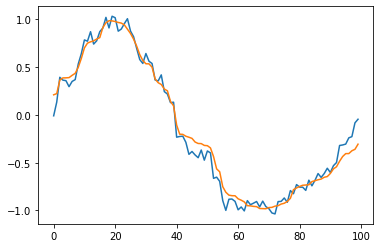

In [41]:
NUM_SAMPLES = 100
X = np.random.uniform(0., 1., NUM_SAMPLES)
X = np.sort(X, axis=0)
noise = np.random.uniform(-0.1, 0.1, NUM_SAMPLES)
y = np.sin(2 * np.pi * X) + noise
rbfnet = RBFNet(lr=0.005, k=2,epochs=500)
rbfnet.fit(X, y)
y_pred = rbfnet.predict(X)
plot(y)
plot(y_pred)

En general probando varios learning rates con diferente número de épocas el mejor resultado obtenido es con un lr de 0.005 y 500 épocas, con 2 bases y diferentes desviaciones estándar por cada base. Aumentar el número de épocas a lo bestia aumenta drásticamente el tiempo de aprendizaje, como es de esperarse, pero no mejora la precisión en general, es posible que termines con curvas muy abiertas y con un modelo no representativo. La tasa de aprendizaje es... inusual, por decir algo, lo mismo terminas con buenos resultados con una tasa alta, y un aprendizaje rápido, que terminas con unas curvas muy fuera de lugar. En general valores pequeños y un decente número de épocas daban los mejores resultados.